In [26]:
import control as ct
from utils import Position, get_acceleration, get_position
import matplotlib.pyplot as plt
import numpy as np

In [27]:
import gym_duckietown

from gym_duckietown.simulator import Simulator
from IPython import display as ipythondisplay

In [28]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)
env = Simulator("small_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[1,0],
    seed=42,
    max_steps=float("inf"),
)
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], 0]

In [29]:
def my_odometry(action, x0, y0, theta0, v0=0, w0=0, dt=0.033):
    """
    Calculate the odometry from the action and the current state.

    :param action: the action to perform
    :param x0: the initial x position
    :param y0: the initial y position
    :param theta0: the initial orientation
    :param v0: the initial linear speed
    :param w0: the initial angular speed
    :param dt: the time step

    :return: (Position, float, float)
    """
    x_dot_dot, w_dot_dot = get_acceleration(action, u=v0, w=w0)

    v1 = v0 + x_dot_dot[0]*dt
    w1 = w0 + w_dot_dot[0]*dt

    # Runge Kutta
    x1 = x0 + v0*dt*np.cos(theta0 + w0*dt/2)
    y1 = y0 + v0*dt*np.sin(theta0 + w0*dt/2)
    theta1 = theta0 + w0*dt

    return Position(x1, y1, theta1), v1, w1

In [30]:
def odom(t, x, u, params):
    dt = params.get('dt', 0.033)

    v0 = u[0]
    w0 = u[1]
    # wl = u[2]
    # wr = u[3]

    x0 = x[0]
    y0 = x[1]
    theta0 = x[2]

    # x_dot_dot, w_dot_dot = get_acceleration([wl, wr], u=v0, w=w0)

    # v1 = v0 + x_dot_dot[0]*dt
    # w1 = w0 + w_dot_dot[0]*dt

    # Runge Kutta
    x1 = x0 + v0*dt*np.cos(theta0 + w0*dt/2)
    y1 = y0 + v0*dt*np.sin(theta0 + w0*dt/2)
    theta1 = theta0 + w0*dt

    return [x1, y1, theta1]

In [31]:
def my_odom_lin(t, x, u, params, intorno_a=None):

    if intorno_a is None:
        intorno_a = x[2]

    dt = params.get('dt', 0.033)

    action = u[0], u[1]

    x0, y0, theta0, v0, w0 = x[0], x[1], x[2], x[3], x[4]

    x_dot_dot, w_dot_dot = get_acceleration(action, u=v0, w=w0)

    v1 = v0 + x_dot_dot[0]*dt
    w1 = w0 + w_dot_dot[0]*dt

    # Runge Kutta
    theta1 = theta0 + w1*dt
    x1 = x0 + v0*dt*np.cos(intorno_a) - v0*dt*np.sin(intorno_a)*w1*dt + dt*np.cos(intorno_a)*x_dot_dot[0]*dt
    y1 = y0 + v0*dt*np.sin(intorno_a) + v0*dt*np.cos(intorno_a)*w1*dt + dt*np.sin(intorno_a)*x_dot_dot[0]*dt

    # u, w = v0, w0

    # u1 = 5
    # w1 = 4
    # # parameters for forced dynamics
    # uar = 1.5
    # ual = 1.5
    # war = 15  # modify this for trim
    # wal = 15

    # u_alpha_r = uar
    # u_alpha_l = ual
    # w_alpha_r = war
    # w_alpha_l = wal
    
    # # wr, wl
    # U = np.array(action)
    # V = U.reshape(U.size, 1)
    # V = np.clip(V, -1, +1)

    # # Previous step linear and angular speed
    # # u, w = longit_prev, angular_prev

    # ## Calculate Dynamics
    # # nonlinear Dynamics - autonomous response
    # f_dynamic = np.array([[-u1 * u ], [-w1 * w]])
    # # input Matrix
    # B = np.array([[u_alpha_r, u_alpha_l], [w_alpha_r, -w_alpha_l]])
    # # forced response
    # f_forced = np.matmul(B, V)
    # # acceleration
    # x_dot_dot = f_dynamic + f_forced

    # w_dot_dot, x_dot_dot = x_dot_dot.reshape(-1)

    u = np.array([[w_dot_dot[0]*dt], [x_dot_dot[0]*dt]])

    A = np.array([[x0 + v0*dt*np.cos(intorno_a) - v0*dt*np.sin(intorno_a)*dt*w0 - v0*dt*np.sin(intorno_a)*dt*w0],
        [y0 + v0*dt*np.sin(intorno_a) + v0*dt*np.cos(intorno_a)*dt*w0],
        [theta0 + w0*dt]])
    B = np.array([[-v0*dt*np.sin(intorno_a)*dt, dt*np.cos(intorno_a)],
        [v0*dt*np.cos(intorno_a)*dt, dt*np.sin(intorno_a)],
        [dt, 0]])

    xdot = A+B@u

    return [*xdot.reshape(-1), v1, w1]
    # return [x1, y1, theta1, v1, w1]

In [32]:
def auto_odom_full(t, x, u, params):
    # Trick is to +1 delay
    dt = params.get('dt', 0.033)

    wl, wr = u[0], u[1]

    x0, y0, theta0, v0, w0 = x[0], x[1], x[2], x[3], x[4]

    x_dot_dot, w_dot_dot = get_acceleration([wl, wr], u=v0, w=w0)
    v1 = v0 + x_dot_dot[0]*dt
    w1 = w0 + w_dot_dot[0]*dt

    # Runge Kutta
    x1 = x0 + v1*dt*np.cos(theta0 + w1*dt/2)
    y1 = y0 + v1*dt*np.sin(theta0 + w1*dt/2)
    theta1 = theta0 + w1*dt

    return [x1, y1, theta1, v1, w1]

In [33]:
io_odom = ct.NonlinearIOSystem(auto_odom_full, None, inputs=('wl', 'wr'), states=('x', 'y', 'th', 'v', 'w'), outputs=('x', 'y', 'th', 'v', 'w'), name='odom', params={'dt': 0.003})

In [34]:
eqpt = ct.find_eqpt(io_odom, [0]*5, [0]*2)
xeq = eqpt[0]

In [35]:
eqpt

(array([0., 0., 0., 0., 0.]), [0, 0])

In [36]:
lin_odom = ct.linearize(io_odom, xeq, 0)

In [37]:
lin_odom.A

array([[1.      , 0.      , 0.      , 0.002955, 0.      ],
       [0.      , 1.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 1.      , 0.      , 0.002964],
       [0.      , 0.      , 0.      , 0.985   , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.988   ]])

In [38]:
lin_odom.B

array([[ 1.3500e-05,  1.3500e-05],
       [-9.1125e-16,  9.1125e-16],
       [-1.3500e-04,  1.3500e-04],
       [ 4.5000e-03,  4.5000e-03],
       [-4.5000e-02,  4.5000e-02]])

In [39]:
lin_odom.C

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [40]:
lin_odom.D

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [41]:
def linearized_odom(action, x0, y0, theta0, v0=0, w0=0, dt=0.033, return_result=False):
    io_odom = ct.NonlinearIOSystem(auto_odom_full, None, inputs=('wl', 'wr'), states=('x', 'y', 'th', 'v', 'w'), outputs=('x', 'y', 'th', 'v', 'w'), name='odom', params={'dt': dt})
    xeq, ueq = ct.find_eqpt(io_odom, [x0, y0, theta0, v0, w0], action, return_result=return_result)
    lin_odom = ct.linearize(io_odom, xeq, 0)
    x = lin_odom.A@[[x0], [y0], [theta0], [v0], [w0]] + lin_odom.B@[[a] for a in action]
    return x.reshape(-1)

In [42]:
action, x0, y0, theta0, v0, w0, dt = [0, 0], 0.7019999, 1.34470641, 0.0, 0, 0, 0.033
io_odom = ct.NonlinearIOSystem(auto_odom_full, None, inputs=('wl', 'wr'), states=('x', 'y', 'th', 'v', 'w'), outputs=('x', 'y', 'th', 'v', 'w'), name='odom', params={'dt': dt})
xeq, ueq = ct.find_eqpt(io_odom, [x0, y0, theta0, v0, w0], action)
lin_odom = ct.linearize(io_odom, xeq, action)
x = lin_odom.A@[[x0], [y0], [theta0], [v0], [w0]] + lin_odom.B@[[a] for a in action]

In [43]:
lin_odom

sys[5]

In [44]:
linearized_odom([0, 0], 0.7019999, 1.34470641, 0.0, v0=0, w0=0, dt=0.033)

array([0.7019999 , 1.34470641, 0.        , 0.        , 0.        ])

In [45]:
auto_odom_full([0, 0], [0.7019999, 1.34470641, 0.0, 0, 0], [0, 0], {'dt': 0.033})

[0.7019999, 1.34470641, 0.0, 0.0, 0.0]

In [46]:
auto_odom_full(0, [0.7019999, 1.34470641, 0.0, 0, 0], [1, 0], {'dt': 0.033})

[0.7036333455164979, 1.3446930685370815, -0.016335000000000002, 0.0495, -0.495]

In [47]:
linearized_odom([1, 0], 0.7019999, 1.34470641, 0.0, v0=0, w0=0, dt=0.033)

array([ 0.70363324,  1.34473309, -0.016335  ,  0.0495    , -0.495     ])

In [48]:
delta_time = 1.0 / env.frame_rate

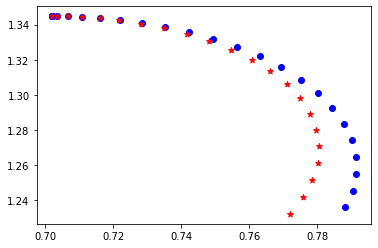

Collision


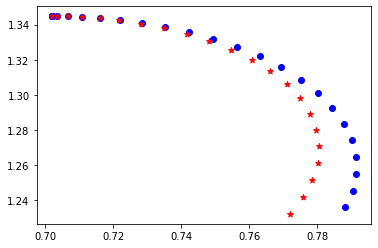

In [49]:
env.reset()
pose = get_position(env)
delay = round(0.15/delta_time)
actions = []
odoms = [pose]
odoms_C = [pose]
poses = []
v_1 = 0
w_1 = 0
v0 = 0
w0 = 0
vc = wc = 0
v = [0,0]
real_v = []
w = [0,0]
# plt.imshow(np.flip(env.render(mode="top_down"), [0]))
for i in range(50):
    action = [1,0]
    actions.append(action)
    obs, reward, done, info = env.step(action)
    if reward == -1000:
        print("Collision")
        break
    # Test odometry
    real_v.append(info["Simulator"]["robot_speed"])
    if len(actions) < delay+1:
        confronto = my_odom_lin(0, [odoms_C[-1].x, odoms_C[-1].y, odoms_C[-1].theta, vc, wc], [0, 0], {'dt': delta_time}, intorno_a=0)
        pc, vc, wc = Position(*confronto[:3]), confronto[3], confronto[4]
        res = my_odom_lin(0, [odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0, w0], [0, 0], {'dt': delta_time}, intorno_a=None)
        # res = linearized_odom([0,0], odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0=v0, w0=w0, dt=delta_time)
        p, v0, w0 = Position(*res[:3]), res[3], res[4]
    else:
        confronto = my_odom_lin(0, [odoms_C[-1].x, odoms_C[-1].y, odoms_C[-1].theta, vc, wc], [action[0], action[1]], {'dt': delta_time}, intorno_a=0)
        pc, vc, wc = Position(*confronto[:3]), confronto[3], confronto[4]
        res = my_odom_lin(0, [odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0, w0], [action[0], action[1]], {'dt': delta_time})
        # res = linearized_odom([action[1], action[0]], odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0=v0, w0=w0, dt=delta_time, return_result=False)
        p, v0, w0 = Position(*res[:3]), res[3], res[4]
    v.append(v0)
    w.append(w0)
    odoms.append(p)
    odoms_C.append(pc)
    try:
        pose = get_position(env)
    except ValueError:
        print(env.cartesian_from_weird(env.cur_pos, env.cur_angle))
        break
    poses.append(pose)
    plt.scatter(pose.x, pose.y, marker="o", c="b")
    # Test odometry
    o = get_position(env)
    plt.scatter(p.x, p.y, marker="*", c="r")
    # plt.scatter(pc.x, pc.y, marker="^", c="g")
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

In [50]:
linearized_odom(action, odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0=v0, w0=w0, dt=delta_time)

array([ 0.78174327,  1.23558268, -1.97237943,  0.29456582, -3.589018  ])

In [51]:
auto_odom_full(0, [odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0, w0], action, {'dt': delta_time})

[0.7686605047549463,
 1.2230623799029248,
 -1.9723794333813847,
 0.29456582222821065,
 -3.5890179997782248]